In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tqdm import tqdm, notebook
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Load data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

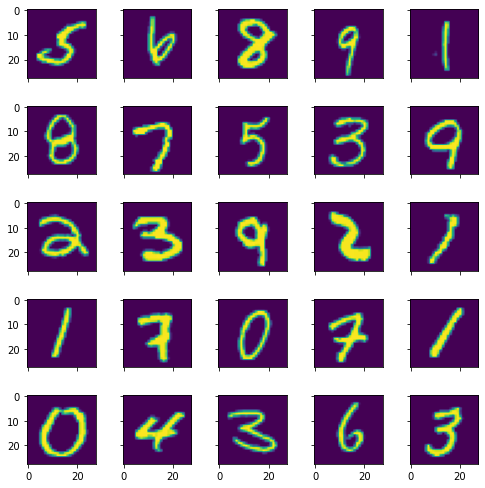

In [3]:
fig, axes = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(7,7))
plt.tight_layout()
for i, ax in enumerate(axes.flatten()):
    ax.imshow(x_train[np.random.randint(0, len(x_train))])
plt.show()

## Filter only for zeros

to reduce training time

In [4]:
only_zeros = x_train[y_train==0]

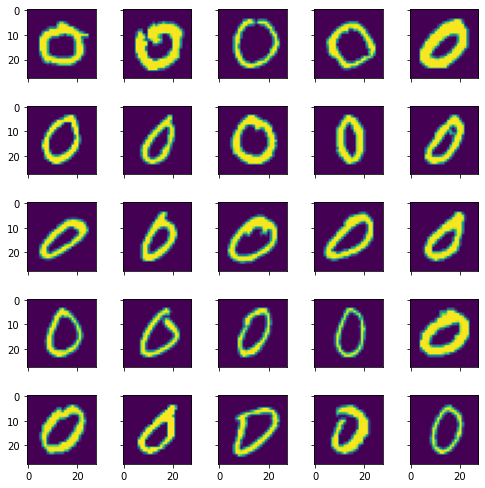

In [5]:
fig, axes = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(7,7))
plt.tight_layout()
for i, ax in enumerate(axes.flatten()):
    ax.imshow(only_zeros[np.random.randint(0, len(only_zeros))])
plt.show()

# Creating the model

In [21]:
discriminator = Sequential()

discriminator.add(Flatten(input_shape=(28, 28)))
discriminator.add(Dense(150, activation='relu'))
discriminator.add(Dense(100, activation='relu'))
discriminator.add(Dense(50, activation='relu'))

discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy',
                     optimizer='adam')
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 150)               117750    
_________________________________________________________________
dense_8 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_9 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 137,951
Trainable params: 137,951
Non-trainable params: 0
_________________________________________________________________


In [22]:
coding_size = 100



In [23]:
generator = Sequential()

generator.add(Dense(50, activation='relu', input_shape=[coding_size]))
generator.add(Dense(100, activation='relu'))
generator.add(Dense(784, activation='relu'))
generator.add(Reshape((28, 28)))

In [24]:
GAN = Sequential([generator, discriminator])

In [25]:
discriminator.trainable = False # false here to compile the GAN

In [26]:
GAN.compile(loss='binary_crossentropy', optimizer='adam')

In [27]:
GAN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 28, 28)            89334     
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 137951    
Total params: 227,285
Trainable params: 89,334
Non-trainable params: 137,951
_________________________________________________________________


In [28]:
batch_size = 32
my_data = only_zeros

dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [29]:
generator, discriminator = GAN.layers

In [37]:
epochs=50
with tf.device('/device:gpu:0'):
    for epoch in notebook.tqdm(range(epochs), desc='Epoch', leave=True):
        i=0
        for x_batch in notebook.tqdm(dataset, desc='Batch:', leave=False):

            noise = tf.random.normal(shape=[batch_size, coding_size])
            gen_img = generator(noise)
            x_fake_vs_real = tf.concat([gen_img, tf.dtypes.cast(x_batch, tf.float32)],
                                       axis=0)
            y1 = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(x_fake_vs_real, y1)

            noise = tf.random.normal(shape=[batch_size, coding_size])
            y2 = tf.constant([[1.0]] * batch_size)
            discriminator.trainable = False
            GAN.train_on_batch(noise, y2)

In [38]:
noise = tf.random.normal(shape=[10, coding_size])

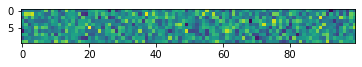

In [39]:
plt.imshow(noise)

In [40]:
images = generator(noise)

## Mode collapse

Always the same output

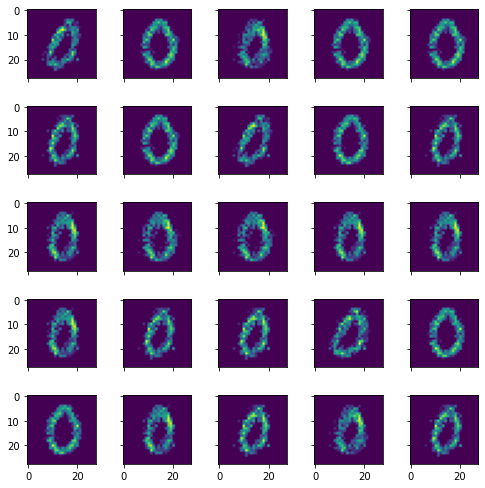

In [41]:
fig, axes = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(7,7))
plt.tight_layout()
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[np.random.randint(0, len(images))])
plt.show()